In [2]:
import os
import copy
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
root_path = os.path.join('.', 'input')
file_path_res_17 = os.path.join(root_path, 'reservation_17.csv')
file_path_res_18 = os.path.join(root_path, 'reservation_18.csv')
file_path_res_19 = os.path.join(root_path, 'reservation_19.csv')

In [4]:
res_17 = pd.read_csv(file_path_res_17, delimiter='\t')
res_18 = pd.read_csv(file_path_res_18, delimiter='\t')
res_19 = pd.read_csv(file_path_res_19, delimiter='\t')

In [5]:
res = pd.concat([res_17, res_18, res_19], axis=0, ignore_index=True)

In [6]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94709 entries, 0 to 94708
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   예약경로           94709 non-null  int64  
 1   예약경로명          94709 non-null  object 
 2   계약번호           94709 non-null  int64  
 3   고객             94709 non-null  int64  
 4   고객구분           94691 non-null  float64
 5   고객구분명          94691 non-null  object 
 6   총 청구액(VAT포함)   94709 non-null  int64  
 7   총 수납금액(VAT포함)  94709 non-null  int64  
 8   총 잔액(VAT포함)    94709 non-null  int64  
 9   예약모델           94709 non-null  object 
 10  예약모델명          94709 non-null  object 
 11  차급             94709 non-null  object 
 12  대여일            94709 non-null  object 
 13  대여시간           94709 non-null  object 
 14  반납일            94709 non-null  object 
 15  반납시간           94709 non-null  object 
 16  대여기간(일)        94709 non-null  int64  
 17  대여기간(시간)       94709 non-null  int64  
 18  실반납일시 

In [7]:
col_remap = {'예약경로': 'rev_route', '예약경로명': 'rev_route_nm', '계약번호': 'rev_num',
             '고객': 'cust_num', '고객구분': 'cust_kind', '고객구분명': 'cust_kind_nm',
             '총 청구액(VAT포함)': 'tot_bill', '총 수납금액(VAT포함)': 'tot_pay',
             '총 잔액(VAT포함)': 'tot_balance', '예약모델': 'rev_model', '예약모델명': 'rev_model_nm',
             '차급': 'car_grd', '대여일': 'rent_day', '대여시간': 'rent_time',
             '반납일': 'return_day', '반납시간': 'return_time', '대여기간(일)': 'rent_period',
             '대여기간(시간)': 'rent_period_time', '실반납일시': 'real_return_time', 
             '실대여기간(일)': 'real_rent_period', '실대여기간(시간)': 'real_rent_time', '차량대여요금(VAT포함)': 'car_rent_fee',
             'CDW가입여부': 'cdw_yn', 'CDW요금구분': 'cdw_fee_kind', 'CDW요금구분명': 'cdw_fee_kind_nm',
             'CDW요금': 'cdw_fee', '회원등급': 'member_grd','차종': 'car_kind', '구매목적': 'rent_purpose',
             '내부매출액': 'in_sales', '수납': 'pay_kind', '예약일자': 'rev_date', '할인유형': 'discount_kind',
             '할인유형명': 'discount_kind_nm', '적용할인명': 'apply_discount_nm'
            }
res.rename(columns=col_remap, inplace=True)

In [8]:
res.columns

Index(['rev_route', 'rev_route_nm', 'rev_num', 'cust_num', 'cust_kind',
       'cust_kind_nm', 'tot_bill', 'tot_pay', 'tot_balance', 'rev_model',
       'rev_model_nm', 'car_grd', 'rent_day', 'rent_time', 'return_day',
       'return_time', 'rent_period', 'rent_period_time', 'real_return_time',
       'real_rent_period', 'real_rent_time', 'car_rent_fee', 'cdw_yn',
       'cdw_fee_kind', 'cdw_fee_kind_nm', 'cdw_fee', 'member_grd', 'car_kind',
       'rent_purpose', 'in_sales', 'pay_kind', 'rev_date', 'discount_kind',
       'discount_kind_nm', 'apply_discount_nm'],
      dtype='object')

In [9]:
# Drop columns
drop_cols = ['tot_pay', 'tot_balance', 'in_sales',
             'cdw_yn','cdw_fee_kind', 'cdw_fee_kind_nm', 
             'car_grd', 'car_kind', 'rent_purpose', 'pay_kind']
res = res.drop(columns=drop_cols, axis=1)

In [10]:
res['rent_day'] = pd.to_datetime(res['rent_day'], format='%Y-%m-%d')
res['return_day'] = pd.to_datetime(res['return_day'], format='%Y-%m-%d')
res['rev_date'] = pd.to_datetime(res['rev_date'], format='%Y-%m-%d')

In [11]:
# 고객 예약 lead time 계산
res['lead_time'] = res['rent_day'] - res['rev_date']
res['lead_time'] = res['lead_time'].apply(lambda x: x.days)

# 매출계 계산
res['car_rent_fee'] = res['car_rent_fee'].astype(int)
res['cdw_fee']  = res['cdw_fee'].astype(int)
res['sales'] = res['car_rent_fee'] + res['cdw_fee']

# 대여시간 계산
res['rent_tot_times'] = res['rent_period'] * 24 + res['rent_period_time']
res['sales_per_times'] = res['sales'] / res['rent_tot_times'] 

In [12]:
res = res.sort_values(by=['rent_day'])
res_17 = copy.deepcopy(res[(res['rent_day'] > pd.to_datetime('20161231', format='%Y-%m-%d')) &
                          (res['rent_day'] <= pd.to_datetime('20171231', format='%Y-%m-%d'))])
res_18 = copy.deepcopy(res[(res['rent_day'] > pd.to_datetime('20171231', format='%Y-%m-%d')) &
                          (res['rent_day'] <= pd.to_datetime('20181231', format='%Y-%m-%d'))])
res_19 = copy.deepcopy(res[(res['rent_day'] > pd.to_datetime('20181231', format='%Y-%m-%d')) &
                          (res['rent_day'] <= pd.to_datetime('20191231', format='%Y-%m-%d'))])

## 2. Analysis based on Rental Day

In [13]:
res_17_grp_by_rent_day = res_17.groupby('rent_day').mean()
res_18_grp_by_rent_day = res_18.groupby('rent_day').mean()
res_19_grp_by_rent_day = res_19.groupby('rent_day').mean()

### 2.1 Lead Time by Rental Day

In [14]:
res_17_lead_time_mean = res_17['lead_time'].mean()
res_18_lead_time_mean = res_18['lead_time'].mean()
res_19_lead_time_mean = res_19['lead_time'].mean()

#### 2.1.1 Lead Time Trend

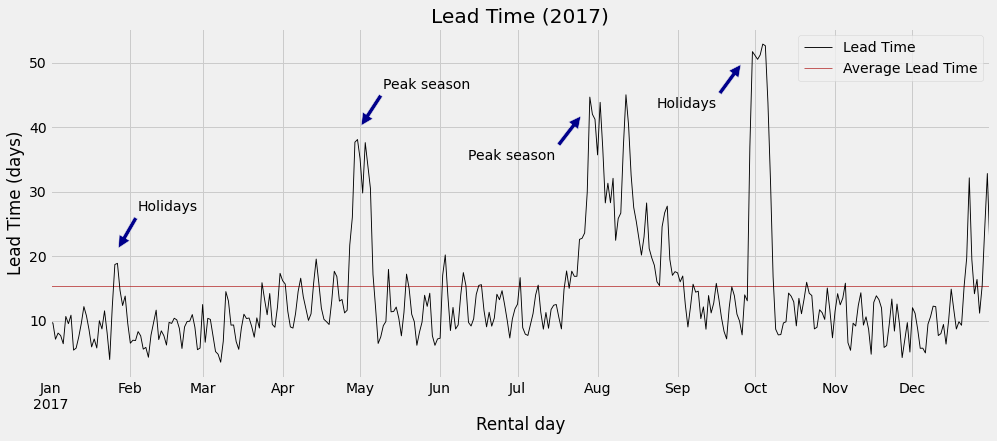

In [99]:
# 2017 year
ax = res_17_grp_by_rent_day['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Lead Time')
ax.hlines(y=res_17_lead_time_mean,
          xmin= res_17_grp_by_rent_day.index[0],
          xmax= res_17_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Lead Time')
ax.set_xlabel('Rental day')
ax.set_ylabel('Lead Time (days)')
ax.annotate('Holidays', xy=(dt.datetime(2017, 1, 27), 21), xytext=(dt.datetime(2017, 2, 4), 27),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 5, 1), 40), xytext=(dt.datetime(2017, 5, 10), 46),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 7, 26), 42), xytext=(dt.datetime(2017, 6, 12), 35),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2017, 9, 26), 50), xytext=(dt.datetime(2017, 8, 24), 43),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Lead Time (2017)')
plt.savefig(os.path.join('.', 'result', 'img', '2017 Lead Time.png'))
plt.show()

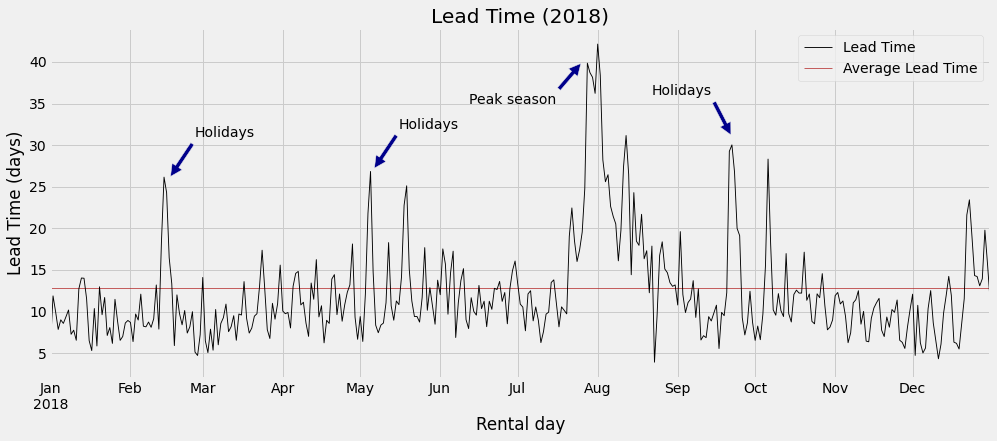

In [98]:
# 2018 year
ax = res_18_grp_by_rent_day['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Lead Time')
ax.hlines(y=res_18_lead_time_mean,
          xmin= res_18_grp_by_rent_day.index[0],
          xmax= res_18_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Lead Time')
ax.set_xlabel('Rental day')
ax.set_ylabel('Lead Time (days)')
ax.annotate('Holidays', xy=(dt.datetime(2018, 2, 16), 26), xytext=(dt.datetime(2018, 2, 26), 31),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 5, 6), 27), xytext=(dt.datetime(2018, 5, 16), 32),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2018, 7, 26), 40), xytext=(dt.datetime(2018, 6, 12), 35),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 9, 22), 31), xytext=(dt.datetime(2018, 8, 22), 36),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Lead Time (2018)')
plt.savefig(os.path.join('.', 'result', 'img', '2018 Lead Time.png'))
plt.show()

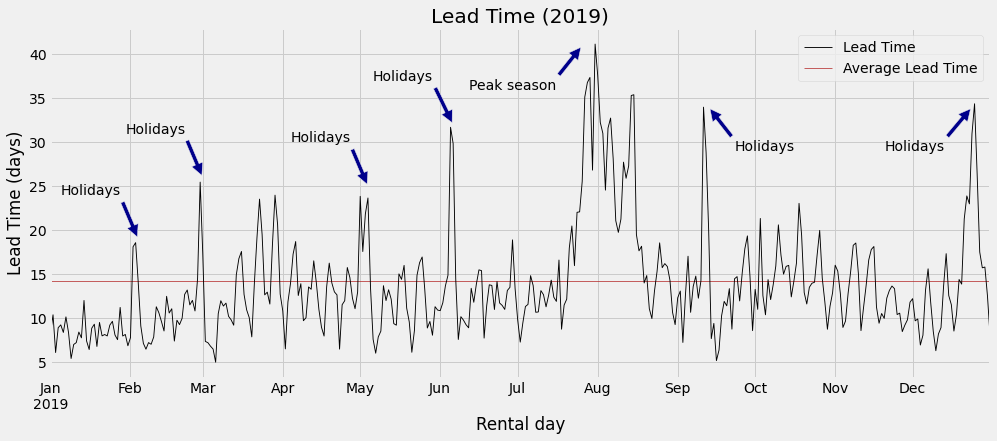

In [97]:
# 2019 year
ax = res_19_grp_by_rent_day['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, color='k', 
                                                   label='Lead Time')
ax.hlines(y=res_19_lead_time_mean,
          xmin= res_19_grp_by_rent_day.index[0],
          xmax= res_19_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Lead Time')
ax.set_xlabel('Rental day')
ax.set_ylabel('Lead Time (days)')
ax.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 19), xytext=(dt.datetime(2019, 1, 5), 24),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 26), xytext=(dt.datetime(2019, 1, 30), 31),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 25), xytext=(dt.datetime(2019, 4, 4), 30),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 32), xytext=(dt.datetime(2019, 5, 6), 37),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 41), xytext=(dt.datetime(2019, 6, 12), 36),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 34), xytext=(dt.datetime(2019, 9, 23), 29),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 34), xytext=(dt.datetime(2019, 11, 20), 29),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Lead Time (2019)')
plt.savefig(os.path.join('.', 'result', 'img', '2019 Lead Time.png'))
plt.show()

### 2.2 Sales by Rental Days

In [18]:
res_17_sales_mean = res_17['sales'].mean()
res_18_sales_mean = res_18['sales'].mean()
res_19_sales_mean = res_19['sales'].mean()

#### 2.2.1 Sales Trend

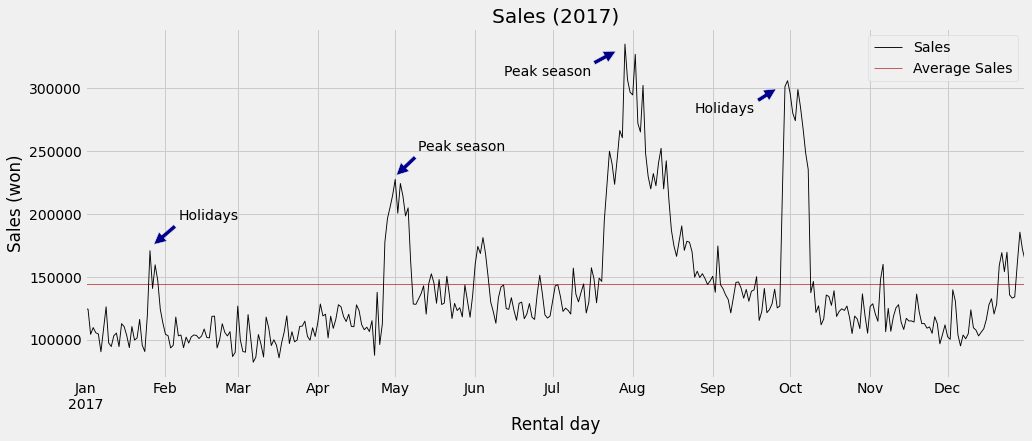

In [96]:
# 2017 year
ax = res_17_grp_by_rent_day['sales'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Sales')
ax.hlines(y=res_17_sales_mean,
          xmin= res_17_grp_by_rent_day.index[0],
          xmax= res_17_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Sales')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales (won)')
ax.annotate('Holidays', xy=(dt.datetime(2017, 1, 27), 175000), xytext=(dt.datetime(2017, 2, 6), 195000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 5, 1), 230000), xytext=(dt.datetime(2017, 5, 10), 250000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 7, 26), 330000), xytext=(dt.datetime(2017, 6, 12), 310000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2017, 9, 26), 300000), xytext=(dt.datetime(2017, 8, 25), 280000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales (2017)')
plt.savefig(os.path.join('.', 'result', 'img', '2017 Sales.png'))
plt.show()

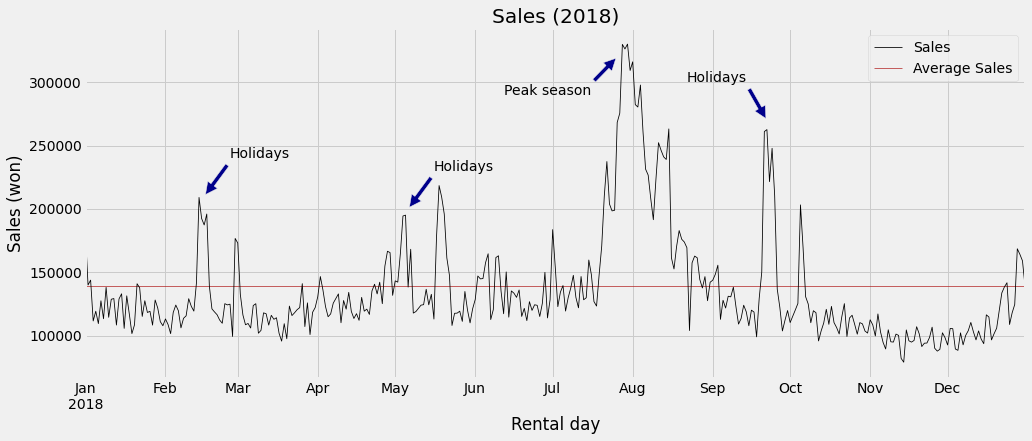

In [20]:
# 2018 year
ax = res_18_grp_by_rent_day['sales'].plot.line(figsize=(15,6), linewidth=0.8, color='k',
                                                   label='Sales')
ax.hlines(y=res_18_sales_mean,
          xmin= res_18_grp_by_rent_day.index[0],
          xmax= res_18_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Sales')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales (won)')
ax.annotate('Holidays', xy=(dt.datetime(2018, 2, 16), 210000), xytext=(dt.datetime(2018, 2, 26), 240000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 5, 6), 200000), xytext=(dt.datetime(2018, 5, 16), 230000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2018, 7, 26), 320000), xytext=(dt.datetime(2018, 6, 12), 290000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 9, 22), 270000), xytext=(dt.datetime(2018, 8, 22), 300000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales (2018)')
plt.savefig(os.path.join('.', 'result', 'img', '2018 Sales.png'))
plt.show()

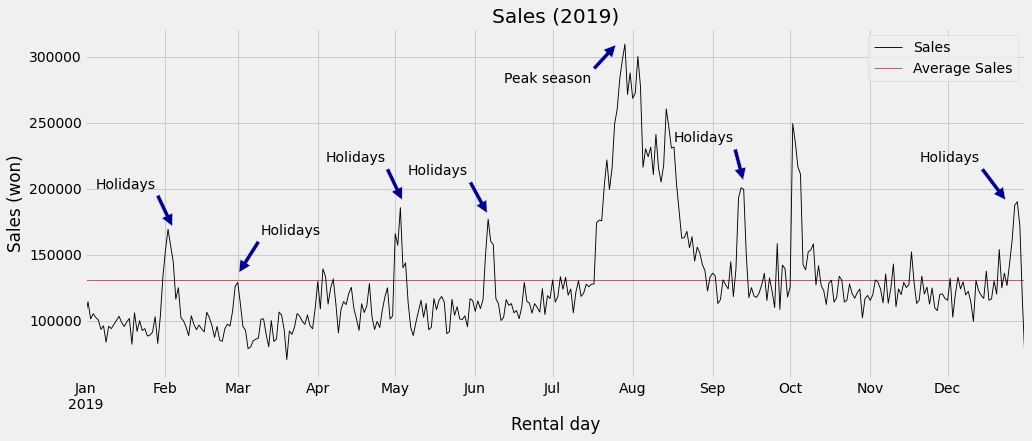

In [95]:
# 2019 year
ax = res_19_grp_by_rent_day['sales'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Sales')
ax.hlines(y=res_19_sales_mean,
          xmin= res_19_grp_by_rent_day.index[0],
          xmax= res_19_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Average Sales')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales (won)')
ax.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 170000), xytext=(dt.datetime(2019, 1, 5), 200000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 135000), xytext=(dt.datetime(2019, 3, 10), 165000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 190000), xytext=(dt.datetime(2019, 4, 4), 220000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 180000), xytext=(dt.datetime(2019, 5, 6), 210000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 310000), xytext=(dt.datetime(2019, 6, 12), 280000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 205000), xytext=(dt.datetime(2019, 8, 17), 235000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 190000), xytext=(dt.datetime(2019, 11, 20), 220000),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales (2019)')
plt.savefig(os.path.join('.', 'result', 'img', '2019 Sales.png'))
plt.show()

In [22]:
res_17_grp_by_rent_day[['lead_time', 'sales', 'sales_per_times']].corr()

,lead_time,sales,sales_per_times
lead_time,1.000000,0.865552,0.625377
sales,0.865552,1.000000,0.804970
sales_per_times,0.625377,0.804970,1.000000


In [23]:
res_18_grp_by_rent_day[['lead_time', 'sales', 'sales_per_times']].corr()

,lead_time,sales,sales_per_times
lead_time,1.000000,0.826937,0.603820
sales,0.826937,1.000000,0.805621
sales_per_times,0.603820,0.805621,1.000000


In [24]:
res_19_grp_by_rent_day[['lead_time', 'sales', 'sales_per_times']].corr()

,lead_time,sales,sales_per_times
lead_time,1.000000,0.719832,0.480365
sales,0.719832,1.000000,0.728640
sales_per_times,0.480365,0.728640,1.000000


In [25]:
scaler = MinMaxScaler()

res_17_scaled = scaler.fit_transform(res_17_grp_by_rent_day)
res_18_scaled = scaler.fit_transform(res_18_grp_by_rent_day)
res_19_scaled = scaler.fit_transform(res_19_grp_by_rent_day)

res_17_grp_by_rent_day_scaled = pd.DataFrame(res_17_scaled,
                                             index=res_17_grp_by_rent_day.index,
                                             columns=res_17_grp_by_rent_day.columns)
res_18_grp_by_rent_day_scaled = pd.DataFrame(res_18_scaled,
                                             index=res_18_grp_by_rent_day.index,
                                             columns=res_18_grp_by_rent_day.columns)
res_19_grp_by_rent_day_scaled = pd.DataFrame(res_19_scaled,
                                             index=res_19_grp_by_rent_day.index,
                                             columns=res_19_grp_by_rent_day.columns)

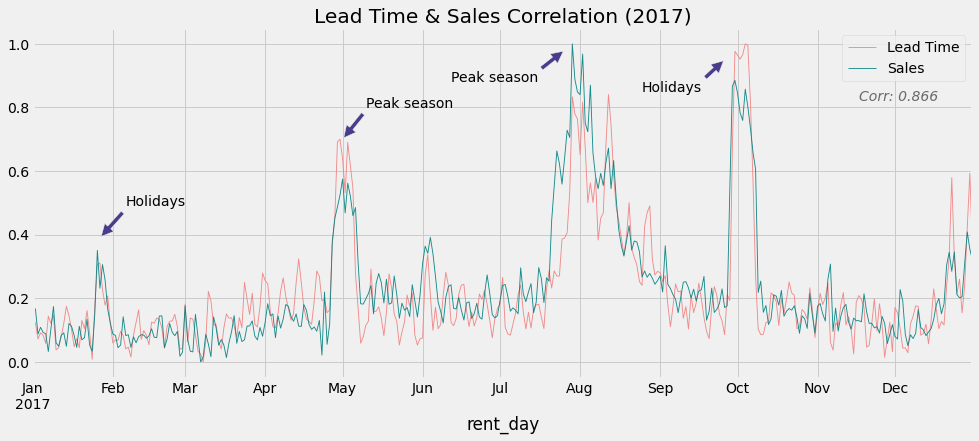

In [94]:
fig, axes = plt.subplots(1, 1)
res_17_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_17_grp_by_rent_day_scaled['sales'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                 color='teal', label='Sales', ax=axes)
axes.legend()
axes.text(dt.datetime(2017, 11, 17), 0.82, 'Corr: 0.866', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2017, 1, 27), 0.39), xytext=(dt.datetime(2017, 2, 6), 0.49),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2017, 5, 1), 0.7), xytext=(dt.datetime(2017, 5, 10), 0.8),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2017, 7, 26), 0.98), xytext=(dt.datetime(2017, 6, 12), 0.88),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2017, 9, 26), 0.95), xytext=(dt.datetime(2017, 8, 25), 0.85),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales Correlation (2017)")
plt.savefig(os.path.join('.', 'result', 'img', '2017 Lead Time & Sales Correlation.png'))

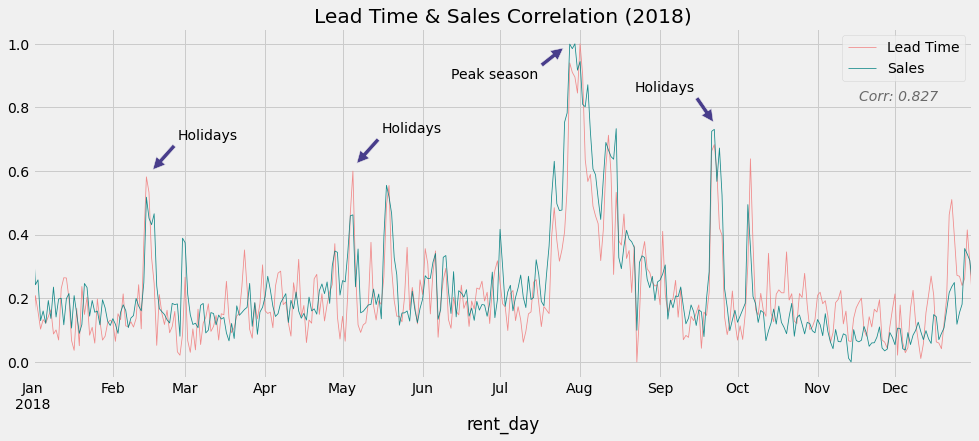

In [27]:
fig, axes = plt.subplots(1, 1)
res_18_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.8, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_18_grp_by_rent_day_scaled['sales'].plot.line(figsize=(15,6), linewidth=0.8, alpha=0.9,
                                                 color='teal', label='Sales', ax=axes)
axes.legend()
axes.text(dt.datetime(2018, 11, 17), 0.82, 'Corr: 0.827', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2018, 2, 16), 0.6), xytext=(dt.datetime(2018, 2, 26), 0.7),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2018, 5, 6), 0.62), xytext=(dt.datetime(2018, 5, 16), 0.72),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2018, 7, 26), 0.99), xytext=(dt.datetime(2018, 6, 12), 0.89),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2018, 9, 22), 0.75), xytext=(dt.datetime(2018, 8, 22), 0.85),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales Correlation (2018)")
plt.savefig(os.path.join('.', 'result', 'img', '2018 Lead Time & Sales Correlation.png'))

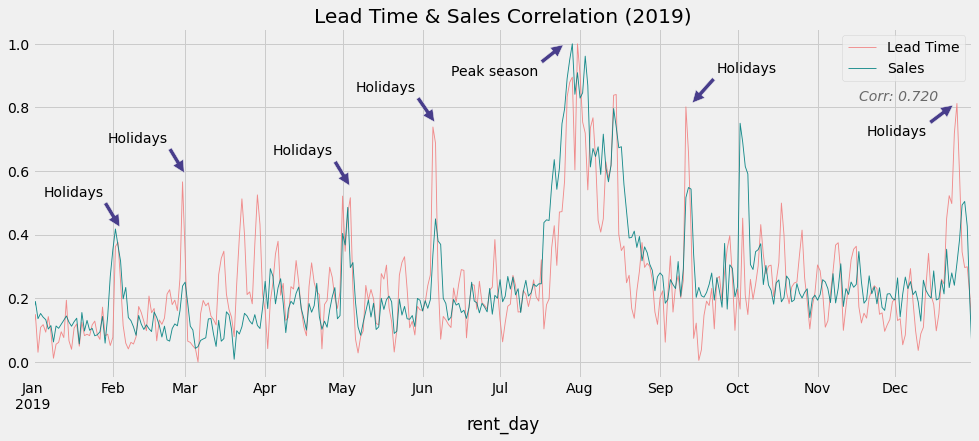

In [93]:
fig, axes = plt.subplots(1, 1)
res_19_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_19_grp_by_rent_day_scaled['sales'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                 color='teal', label='Sales', ax=axes)
axes.legend()
axes.text(dt.datetime(2019, 11, 17), 0.82, 'Corr: 0.720', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 0.42), xytext=(dt.datetime(2019, 1, 5), 0.52),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 0.59), xytext=(dt.datetime(2019, 1, 30), 0.69),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 0.55), xytext=(dt.datetime(2019, 4, 4), 0.65),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 0.75), xytext=(dt.datetime(2019, 5, 6), 0.85),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 1), xytext=(dt.datetime(2019, 6, 12), 0.9),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 0.81), xytext=(dt.datetime(2019, 9, 23), 0.91),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 0.81), xytext=(dt.datetime(2019, 11, 20), 0.71),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales Correlation (2019)")
plt.savefig(os.path.join('.', 'result', 'img', '2019 Lead Time & Sales Correlation.png'))

### Sales per Times by Rental Day

In [29]:
res_17_sales_per_times_mean = res_17['sales_per_times'].mean()
res_18_sales_per_times_mean = res_18['sales_per_times'].mean()
res_19_sales_per_times_mean = res_19['sales_per_times'].mean()

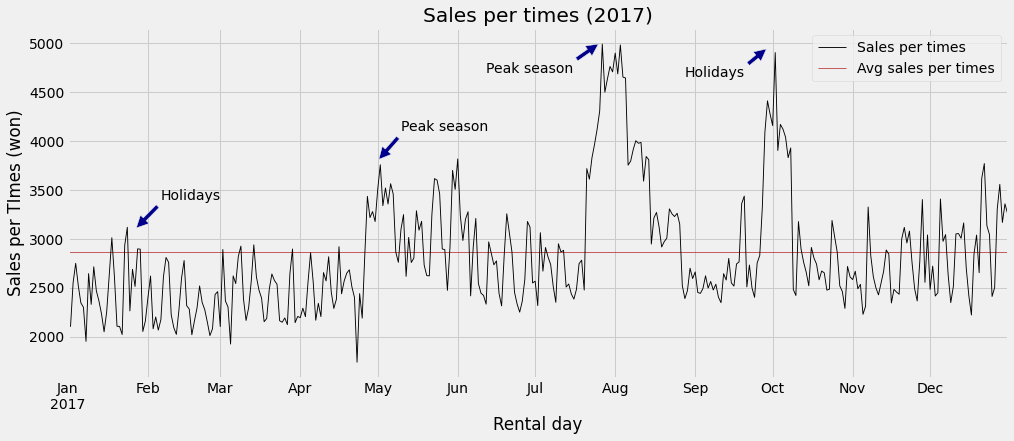

In [92]:
# 2017 year
ax = res_17_grp_by_rent_day['sales_per_times'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Sales per times')
ax.hlines(y=res_17_sales_per_times_mean,
          xmin= res_17_grp_by_rent_day.index[0],
          xmax= res_17_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Avg sales per times')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales per TImes (won)')
ax.annotate('Holidays', xy=(dt.datetime(2017, 1, 27), 3100), xytext=(dt.datetime(2017, 2, 6), 3400),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 5, 1), 3800), xytext=(dt.datetime(2017, 5, 10), 4100),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2017, 7, 26), 5000), xytext=(dt.datetime(2017, 6, 12), 4700),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2017, 9, 29), 4950), xytext=(dt.datetime(2017, 8, 28), 4650),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales per times (2017)')
plt.savefig(os.path.join('.', 'result', 'img', '2017 Sales per Times.png'))
plt.show()

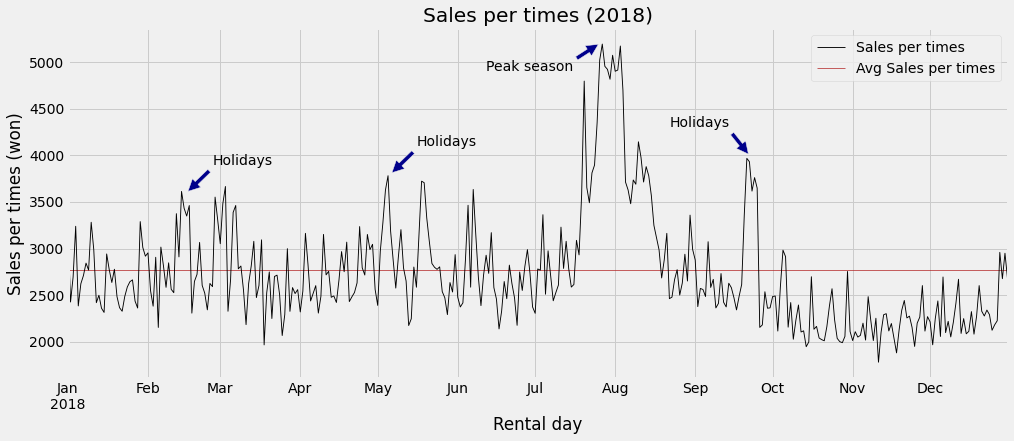

In [91]:
# 2018 year
ax = res_18_grp_by_rent_day['sales_per_times'].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Sales per times')
ax.hlines(y=res_18_sales_per_times_mean,
          xmin= res_18_grp_by_rent_day.index[0],
          xmax= res_18_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Avg Sales per times')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales per times (won)')
ax.annotate('Holidays', xy=(dt.datetime(2018, 2, 16), 3600), xytext=(dt.datetime(2018, 2, 26), 3900),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 5, 6), 3800), xytext=(dt.datetime(2018, 5, 16), 4100),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2018, 7, 26), 5200), xytext=(dt.datetime(2018, 6, 12), 4900),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2018, 9, 22), 4000), xytext=(dt.datetime(2018, 8, 22), 4300),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales per times (2018)')
plt.savefig(os.path.join('.', 'result', 'img', '2018 Sales per Times.png'))
plt.show()

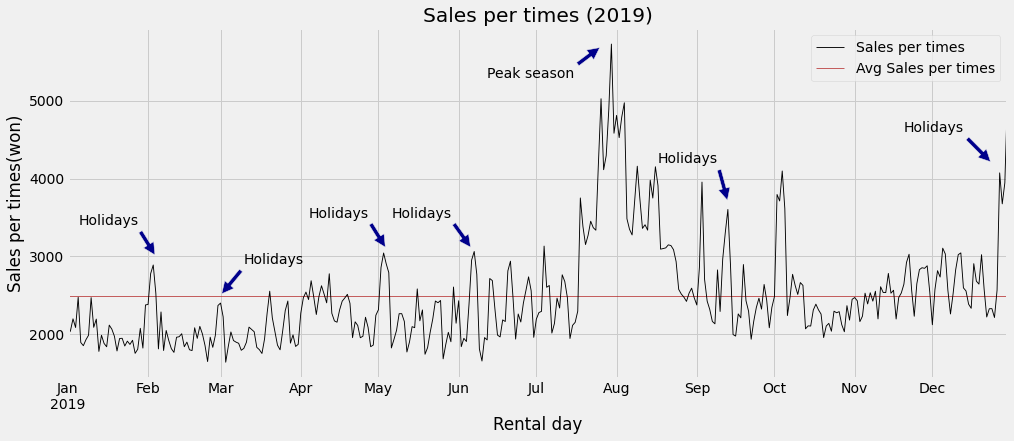

In [90]:
# 2019 year
ax = res_19_grp_by_rent_day['sales_per_times'][:-1].plot.line(figsize=(15,6), linewidth=0.9, color='k',
                                                   label='Sales per times')
ax.hlines(y=res_19_sales_per_times_mean,
          xmin= res_19_grp_by_rent_day.index[0],
          xmax= res_19_grp_by_rent_day.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Avg Sales per times')
ax.set_xlabel('Rental day')
ax.set_ylabel('Sales per times(won)')
ax.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 3000), xytext=(dt.datetime(2019, 1, 5), 3400),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 2500), xytext=(dt.datetime(2019, 3, 10), 2900),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 3100), xytext=(dt.datetime(2019, 4, 4), 3500),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 3100), xytext=(dt.datetime(2019, 5, 6), 3500),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 5700), xytext=(dt.datetime(2019, 6, 12), 5300),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 3700), xytext=(dt.datetime(2019, 8, 17), 4200),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 4200), xytext=(dt.datetime(2019, 11, 20), 4600),
            arrowprops=dict(facecolor='darkblue', shrink=0.05))
ax.legend()
plt.title('Sales per times (2019)')
plt.savefig(os.path.join('.', 'result', 'img', '2019 Sales per Times.png'))
plt.show()

#### Lead Time vs Sales per Times

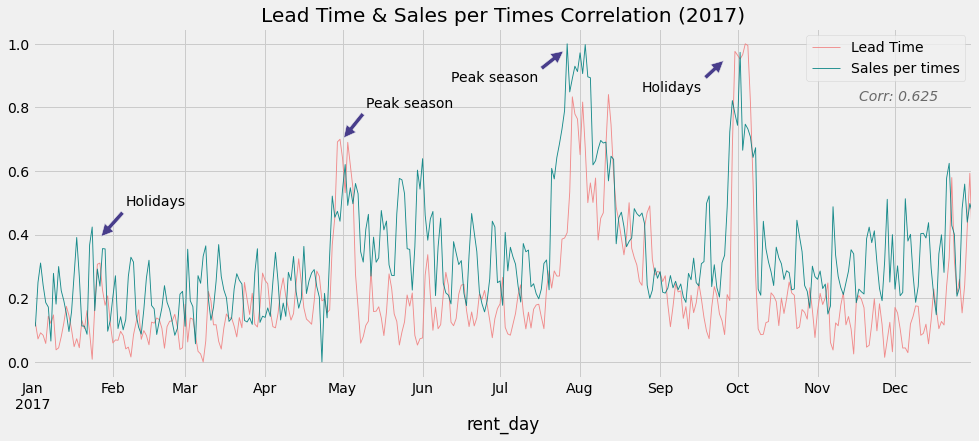

In [100]:
fig, axes = plt.subplots(1, 1)
res_17_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_17_grp_by_rent_day_scaled['sales_per_times'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                 color='teal', label='Sales per times', ax=axes)
axes.legend()
axes.text(dt.datetime(2017, 11, 17), 0.82, 'Corr: 0.625', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2017, 1, 27), 0.39), xytext=(dt.datetime(2017, 2, 6), 0.49),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2017, 5, 1), 0.7), xytext=(dt.datetime(2017, 5, 10), 0.8),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2017, 7, 26), 0.98), xytext=(dt.datetime(2017, 6, 12), 0.88),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2017, 9, 26), 0.95), xytext=(dt.datetime(2017, 8, 25), 0.85),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales per Times Correlation (2017)")
plt.savefig(os.path.join('.', 'result', 'img', '2017 Lead Time & Sales per Times Correlation.png'))

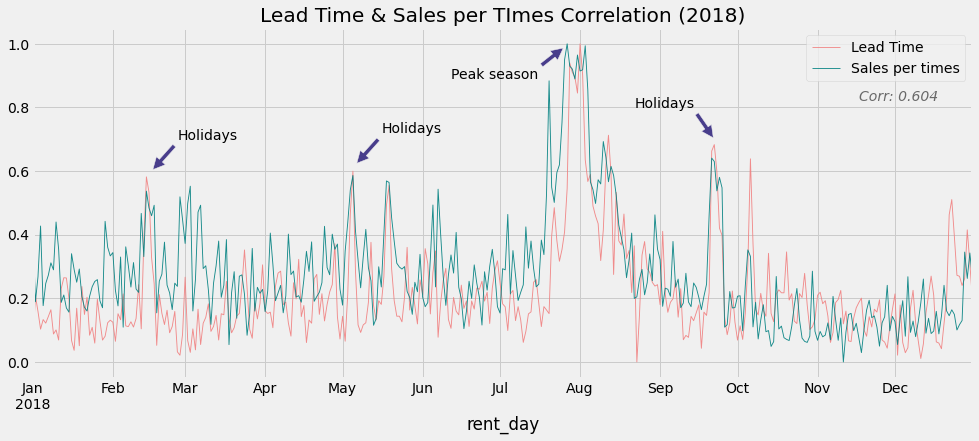

In [101]:
fig, axes = plt.subplots(1, 1)
res_18_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_18_grp_by_rent_day_scaled['sales_per_times'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                 color='teal', label='Sales per times', ax=axes)
axes.legend()
axes.text(dt.datetime(2018, 11, 17), 0.82, 'Corr: 0.604', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2018, 2, 16), 0.6), xytext=(dt.datetime(2018, 2, 26), 0.7),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2018, 5, 6), 0.62), xytext=(dt.datetime(2018, 5, 16), 0.72),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2018, 7, 26), 0.99), xytext=(dt.datetime(2018, 6, 12), 0.89),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2018, 9, 22), 0.7), xytext=(dt.datetime(2018, 8, 22), 0.8),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales per TImes Correlation (2018)")
plt.savefig(os.path.join('.', 'result', 'img', '2018 Lead Time & Sales per Times Correlation.png'))

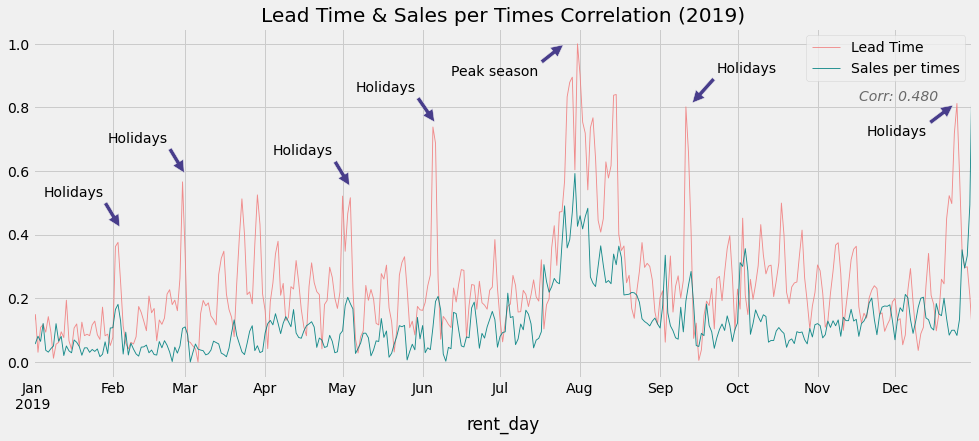

In [102]:
fig, axes = plt.subplots(1, 1)
res_19_grp_by_rent_day_scaled['lead_time'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                     color='lightcoral', label='Lead Time', ax=axes)
res_19_grp_by_rent_day_scaled['sales_per_times'].plot.line(figsize=(15,6), linewidth=0.9, alpha=0.9,
                                                 color='teal', label='Sales per times', ax=axes)
axes.legend()
axes.text(dt.datetime(2019, 11, 17), 0.82, 'Corr: 0.480', 
          style='italic', color='dimgray')
axes.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 0.42), xytext=(dt.datetime(2019, 1, 5), 0.52),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 0.59), xytext=(dt.datetime(2019, 1, 30), 0.69),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 0.55), xytext=(dt.datetime(2019, 4, 4), 0.65),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 0.75), xytext=(dt.datetime(2019, 5, 6), 0.85),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 1), xytext=(dt.datetime(2019, 6, 12), 0.9),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 0.81), xytext=(dt.datetime(2019, 9, 23), 0.91),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
axes.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 0.81), xytext=(dt.datetime(2019, 11, 20), 0.71),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
plt.title("Lead Time & Sales per Times Correlation (2019)")
plt.savefig(os.path.join('.', 'result', 'img', '2019 Lead Time & Sales per Times Correlation.png'))

### Jeju

In [104]:
file_path_jeju = os.path.join(root_path, 'jeju_daily.csv')
jeju_daily = pd.read_csv(file_path_jeju, delimiter='\t')
jeju_daily.head()

,yyyymmdd,domestic,foreign,total
0,20170101,NaN,NaN,NaN
1,20170102,NaN,NaN,NaN
2,20170103,NaN,NaN,NaN
3,20170104,NaN,NaN,NaN
4,20170105,NaN,NaN,NaN


In [139]:
jeju_daily = jeju_daily.fillna(0)
jeju_daily['domestic'].astype(int)
jeju_daily['foreign'].astype(int)
jeju_daily['total'].astype(int)
jeju_daily.head()

,yyyymmdd,domestic,foreign,total,date
date,,,,,
2017-01-01,20170101,0.0,0.0,0.0,2017-01-01
2017-01-02,20170102,0.0,0.0,0.0,2017-01-02
2017-01-03,20170103,0.0,0.0,0.0,2017-01-03
2017-01-04,20170104,0.0,0.0,0.0,2017-01-04
2017-01-05,20170105,0.0,0.0,0.0,2017-01-05


In [108]:
jeju_daily['date'] = pd.to_datetime(jeju_daily['yyyymmdd'], format="%Y%m%d")
jeju_daily = jeju_daily.set_index('date', drop=False)
jeju_daily.head()

,yyyymmdd,domestic,foreign,total,date
date,,,,,
2017-01-01,20170101,0.0,0.0,0.0,2017-01-01
2017-01-02,20170102,0.0,0.0,0.0,2017-01-02
2017-01-03,20170103,0.0,0.0,0.0,2017-01-03
2017-01-04,20170104,0.0,0.0,0.0,2017-01-04
2017-01-05,20170105,0.0,0.0,0.0,2017-01-05


In [109]:
jeju_daily_19 = jeju_daily[(jeju_daily['yyyymmdd'] >=20190101) & (jeju_daily['yyyymmdd'] < 20200101)]
jeju_daily_19 = jeju_daily_19.drop(columns=['yyyymmdd'], axis=1)
jeju_daily_19.head()

,domestic,foreign,total,date
date,,,,
2019-01-01,28147.0,3085.0,31232.0,2019-01-01
2019-01-02,33918.0,2626.0,36544.0,2019-01-02
2019-01-03,32242.0,2882.0,35124.0,2019-01-03
2019-01-04,31761.0,2940.0,34701.0,2019-01-04
2019-01-05,32063.0,3294.0,35357.0,2019-01-05


In [110]:
jeju_daily_19_dom_mean = round(jeju_daily_19['domestic'].mean(), 2)
jeju_daily_19_frn_mean = round(jeju_daily_19['foreign'].mean(), 2)
jeju_daily_19_tot_mean = round(jeju_daily_19['total'].mean(), 2)

print(f'Mean of domestic: {jeju_daily_19_dom_mean}')
print(f'Mean of foreign: {jeju_daily_19_frn_mean}')
print(f'Mean of total: {jeju_daily_19_tot_mean}')

Mean of domestic: 36971.97
Mean of foreign: 4769.67
Mean of total: 41741.64


<AxesSubplot:xlabel='date'>

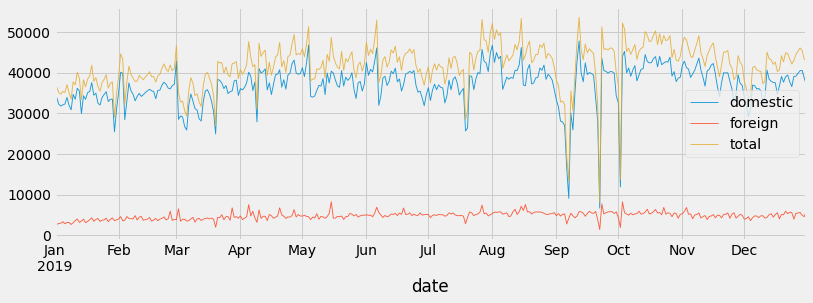

In [113]:
jeju_daily_19[['domestic', 'foreign', 'total']].plot.line(figsize=(12, 4), linewidth=0.9, alpha=0.9)

Text(0.0, 1.0, 'Tourists Trend')

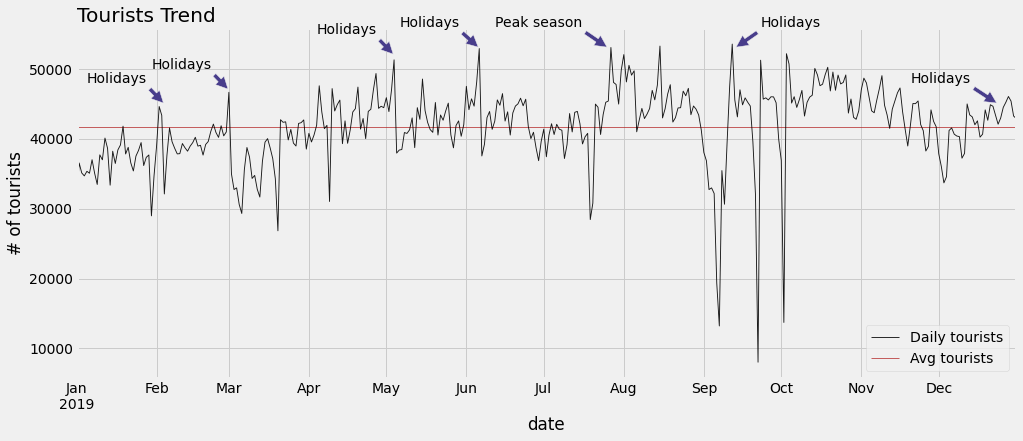

In [114]:
ax = jeju_daily_19['total'].plot.line(figsize=(15, 6), linewidth=0.9, alpha=0.9, color='k', 
                                      label='Daily tourists')

ax.hlines(y=jeju_daily_19_tot_mean,
          xmin= jeju_daily_19.index[0],
          xmax= jeju_daily_19.index[-1],
          ls='-', color='firebrick', linewidth=0.7,
          label='Avg tourists')

ax.set_xlabel('date')
ax.set_ylabel('# of tourists')
ax.annotate('Holidays', xy=(dt.datetime(2019, 2, 4), 45000), xytext=(dt.datetime(2019, 1, 5), 48000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 3, 1), 47000), xytext=(dt.datetime(2019, 1, 30), 50000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 5, 4), 52000), xytext=(dt.datetime(2019, 4, 4), 55000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 6, 6), 53000), xytext=(dt.datetime(2019, 5, 6), 56000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Peak season', xy=(dt.datetime(2019, 7, 26), 53000), xytext=(dt.datetime(2019, 6, 12), 56000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 9, 13), 53000), xytext=(dt.datetime(2019, 9, 23), 56000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))
ax.annotate('Holidays', xy=(dt.datetime(2019, 12, 24), 45000), xytext=(dt.datetime(2019, 11, 20), 48000),
            arrowprops=dict(facecolor='darkslateblue', shrink=0.05))

ax.legend(loc="lower right")
plt.title('Tourists Trend', loc='left')

In [153]:
res_19_simple =copy.deepcopy(res_19_grp_by_rent_day[['lead_time', 'sales' ,'rent_tot_times', 'sales_per_times']])
res_19_simple = res_19_simple.reset_index()
res_19_simple.rename(columns={'rent_day': 'date'}, inplace=True)
res_19_simple.head()

,date,lead_time,sales,rent_tot_times,sales_per_times
0,2019-01-01,8.244444,103778.666667,52.622222,1993.143901
1,2019-01-02,10.378049,114223.292683,65.426829,2039.295001
2,2019-01-03,6.086957,101185.108696,58.108696,2195.670261
3,2019-01-04,8.913043,105126.666667,50.391304,2083.803920
4,2019-01-05,9.230769,102333.576923,44.217949,2472.699968


In [202]:
res_cnt_19 = res_19.groupby('rent_day').count()
res_cnt_19 = pd.DataFrame(res_cnt_19['cust_num'].values, index=res_cnt_19.index, columns=['res_cnt']) 
res_cnt_19 = res_cnt_19.reset_index()
res_cnt_19.head()

,rent_day,res_cnt
0,2019-01-01,45
1,2019-01-02,82
2,2019-01-03,92
3,2019-01-04,69
4,2019-01-05,78


In [204]:
res_19_simple = pd.concat([res_19_simple, res_cnt_19], axis=1)
res_19_simple = res_19_simple.drop(columns=['rent_day'], axis=1)
res_19_simple.head()

,date,lead_time,sales,rent_tot_times,sales_per_times,res_cnt
0,2019-01-01,8.244444,103778.666667,52.622222,1993.143901,45
1,2019-01-02,10.378049,114223.292683,65.426829,2039.295001,82
2,2019-01-03,6.086957,101185.108696,58.108696,2195.670261,92
3,2019-01-04,8.913043,105126.666667,50.391304,2083.803920,69
4,2019-01-05,9.230769,102333.576923,44.217949,2472.699968,78


In [205]:
df_19 = res_19_simple.join(jeju_daily_19, on='date', how='inner', lsuffix='_caller', rsuffix='_other')
df_19 = df_19.drop(columns=['date_caller', 'date_other'], axis=1)
df_19.rename(columns={'domestic': 'tour_dom', 'foreign': 'tour_for', 'total': 'tour_tot'}, inplace=True)
df_19['date'] = pd.to_datetime(df_19['date'], format='%Y-%m-%d')
df_19 = df_19.set_index('date', drop=True)
df_19['tour_dom'] = df_19['tour_dom'].astype(int)
df_19['tour_for'] = df_19['tour_for'].astype(int)
df_19['tour_tot'] = df_19['tour_tot'].astype(int)

In [206]:
df_19.head()

,lead_time,sales,rent_tot_times,sales_per_times,res_cnt,tour_dom,tour_for,tour_tot
date,,,,,,,,
2019-01-01,8.244444,103778.666667,52.622222,1993.143901,45,28147,3085,31232
2019-01-02,10.378049,114223.292683,65.426829,2039.295001,82,33918,2626,36544
2019-01-03,6.086957,101185.108696,58.108696,2195.670261,92,32242,2882,35124
2019-01-04,8.913043,105126.666667,50.391304,2083.803920,69,31761,2940,34701
2019-01-05,9.230769,102333.576923,44.217949,2472.699968,78,32063,3294,35357


In [207]:
df_19.corr()

,lead_time,sales,rent_tot_times,sales_per_times,res_cnt,tour_dom,tour_for,tour_tot
lead_time,1.000000,0.719832,0.325668,0.480365,0.244049,0.469019,0.405295,0.486418
sales,0.719832,1.000000,0.481739,0.728640,0.140146,0.323405,0.390487,0.354166
rent_tot_times,0.325668,0.481739,1.000000,-0.115128,0.252964,0.128185,0.151343,0.139798
sales_per_times,0.480365,0.728640,-0.115128,1.000000,-0.110875,0.236010,0.334203,0.266781
res_cnt,0.244049,0.140146,0.252964,-0.110875,1.000000,0.493015,0.308351,0.491414
tour_dom,0.469019,0.323405,0.128185,0.236010,0.493015,1.000000,0.589219,0.990632
tour_for,0.405295,0.390487,0.151343,0.334203,0.308351,0.589219,1.000000,0.694036
tour_tot,0.486418,0.354166,0.139798,0.266781,0.491414,0.990632,0.694036,1.000000


In [208]:
scaler = MinMaxScaler()
df_19_scaled = scaler.fit_transform(df_19)
df_19_scaled = pd.DataFrame(df_19_scaled, index=df_19.index, columns=df_19.columns)
df_19_scaled.head()

,lead_time,sales,rent_tot_times,sales_per_times,res_cnt,tour_dom,tour_for,tour_tot
date,,,,,,,,
2019-01-01,0.090028,0.146718,0.638613,0.051482,0.323529,0.522988,0.247364,0.509487
2019-01-02,0.148986,0.190033,0.821866,0.058158,0.595588,0.663295,0.180141,0.626142
2019-01-03,0.030410,0.135963,0.717133,0.080779,0.669118,0.622547,0.217633,0.594958
2019-01-04,0.108504,0.152309,0.606685,0.064597,0.500000,0.610853,0.226128,0.585668
2019-01-05,0.117283,0.140725,0.518335,0.120855,0.566176,0.618196,0.277973,0.600075


<AxesSubplot:xlabel='date'>

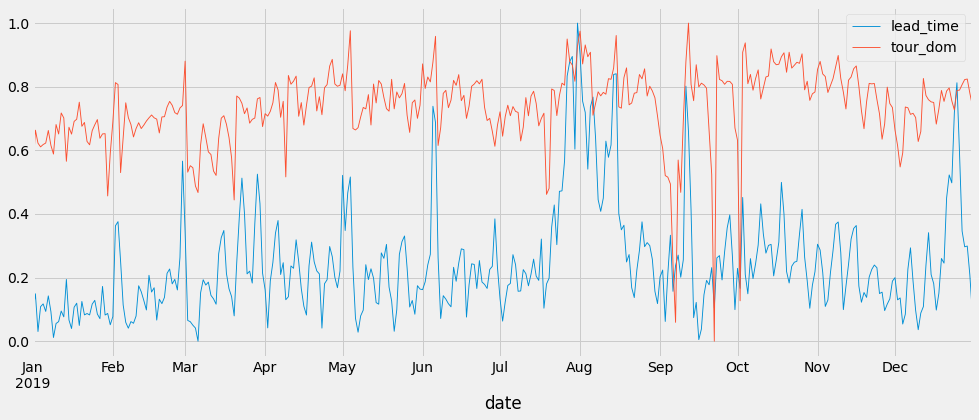

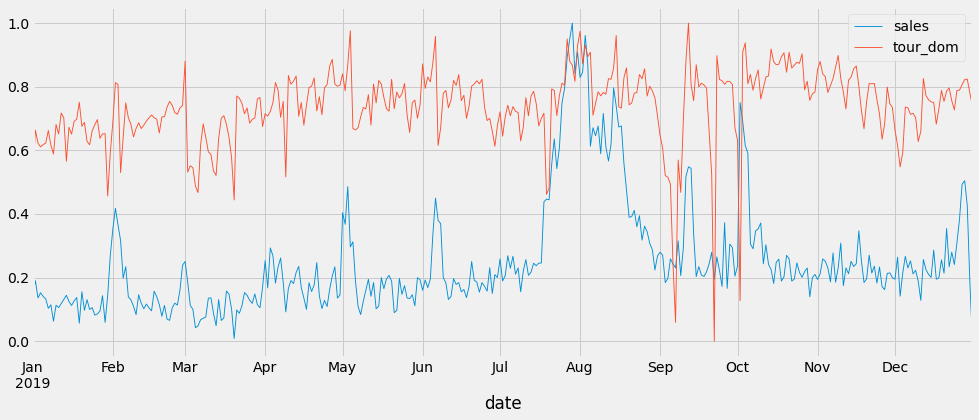

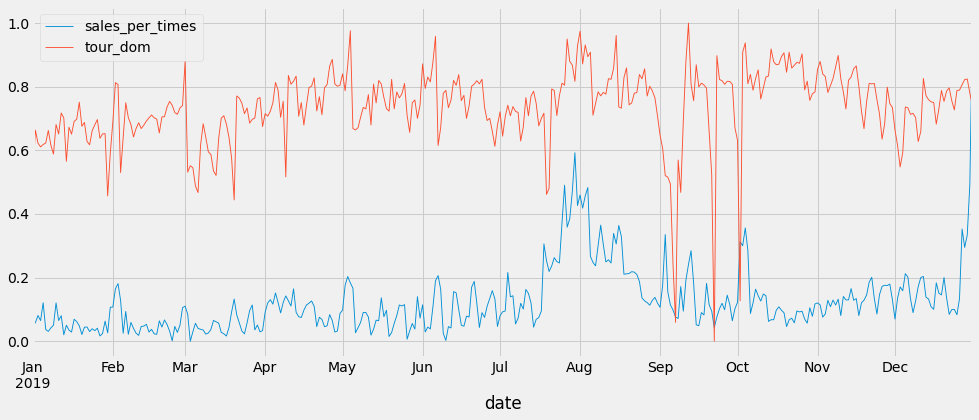

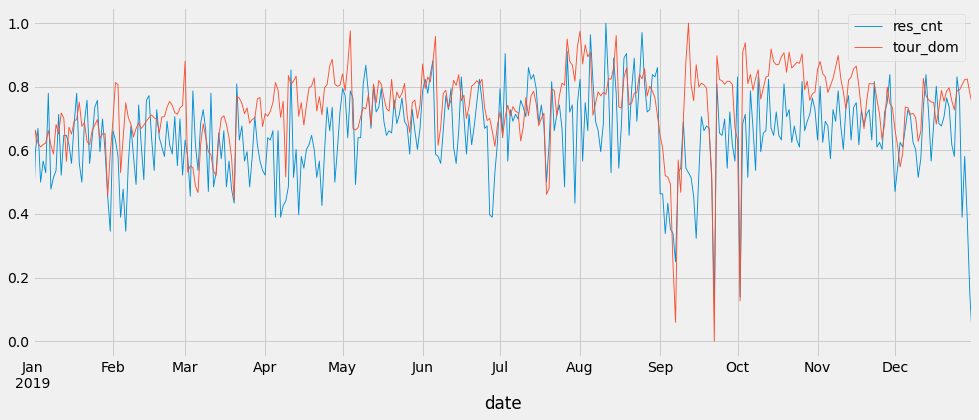

In [209]:
figsize= (15,6)
linewidth = 0.9

df_19_scaled[['lead_time', 'tour_dom']].plot.line(figsize=figsize, linewidth=linewidth)
df_19_scaled[['sales', 'tour_dom']].plot.line(figsize=figsize, linewidth=linewidth)
df_19_scaled[['sales_per_times', 'tour_dom']].plot.line(figsize=figsize, linewidth=linewidth)
df_19_scaled[['res_cnt', 'tour_dom']].plot.line(figsize=figsize, linewidth=linewidth)